In [ ]:
using Revise

using LinearAlgebra, QuadGK, Roots, FFTW, FastGaussQuadrature, SpecialFunctions
using Triangulate
using VlasovSolvers
import VlasovSolvers: advection!
import VlasovSolvers: samples, Particles, PF_step!, ParticleMover, kernel_poisson!, kernel_gyrokinetic!

using ProgressMeter, Printf
using Plots, LaTeXStrings

# Quadrature rules

In [ ]:
struct RectangleRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function RectangleRule(len, start, stop)
        points = LinRange(start, stop, len+1)[1:end-1]
        s = step(points) 
        weights = [s for _ = 1:len]
        new(len, start, stop, vec(points), weights, s)
    end
end

In [ ]:
struct TrapezoidalRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function TrapezoidalRule(len, start, stop)
        points = LinRange(start, stop, len)[1:end]
        s = step(points) 
        weights = [s for _ = 1:len]
        weights[1] /= 2
        weights[end] /= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [ ]:
struct SimpsonRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function SimpsonRule(len, start, stop)
        # make sure the number of points is uneven
        if len % 2 == 0
            len += 1
        end
        points = LinRange(start, stop, len)
        s = step(points) 
        weights = s/3 .* ones(len)
        weights[2:2:end-1] .*= 4
        weights[3:2:end-2] .*= 2
        new(len, start, stop, vec(points), weights, s)
    end
end

In [ ]:
struct GaussHermiteRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussHermiteRule(len, start, stop)
        points, weights = gausshermite(len)
        weights .*= exp.(points.^2)
        new(len, start, stop, points, weights)
    end
end

In [ ]:
struct GaussLegendreRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLegendreRule(len, start, stop)
        points, weights = gausslegendre(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [ ]:
struct GaussRadauRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussRadauRule(len, start, stop)
        points, weights = gaussradau(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [ ]:
struct GaussLobattoRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Array{Float64}
    weights :: Array{Float64}

    function GaussLobattoRule(len, start, stop)
        points, weights = gausslobatto(len)
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        new(len, start, stop, points, weights)
    end
end

In [ ]:
struct KronrodRule
    len  :: Int64
    start :: Float64
    stop  :: Float64
    points :: Vector{Float64}
    weights :: Vector{Float64}
    step :: Float64

    function KronrodRule(len, start, stop)
        pts, w, _ = kronrod(len)
        weights = []
        points = []
        for i = 1:len
            push!(points, pts[i])
            push!(weights, w[i])
            push!(points, -pts[i])
            push!(weights, w[i])
        end
        push!(points, pts[end])
        push!(weights, w[end])
        
        points .+= 1
        points .*= (stop - start) / 2
        points .+= start
        weights .*= (stop - start) / 2
        len = 2*len + 1
        new(len, start, stop, points, weights)
end
    end

In [ ]:
# Only works for rectangle and trapezoidal rules
function projection_onto_grid!(grid_dst, meshx, meshv, X, V_, W)
    meshxstep = meshx[2] - meshx[1]
    meshvstep = meshv[2] - meshv[1]
    grid_dst .= 0


    # Periodic Boundary conditions on velocity
    V = copy(V_)
    V[findall(v -> v >= meshv[end],  V)] .-= meshv[end] - meshv[1]
    V[findall(v -> v < meshv[1],  V)] .+= meshv[end] - meshv[1]
    
    for ipart = 1:length(X)
        idxgridx = Int64(fld(X[ipart],            meshxstep)) + 1
        idxgridv = Int64(fld(V[ipart] - meshv[1], meshvstep)) + 1
        idxgridxp1 = idxgridx<length(meshx) ? idxgridx+1 : 1
        idxgridvp1 = idxgridv<length(meshv) ? idxgridv+1 : 1
        
        tx = (X[ipart]             - (idxgridx-1) * meshxstep) / meshxstep
        tv = (V[ipart] - meshv[1]  - (idxgridv-1) * meshvstep) / meshvstep

        # println((idxgridv, V[ipart]))
        grid_dst[idxgridx  , idxgridv  ] += W[ipart] * (1-tx) * (1-tv)
        grid_dst[idxgridx  , idxgridvp1] += W[ipart] * (1-tx) * tv
        grid_dst[idxgridxp1, idxgridvp1] += W[ipart] * tx     * tv
        grid_dst[idxgridxp1, idxgridv  ] += W[ipart] * tx     * (1 - tv)
    end
end

# Numerical examples

In [ ]:
struct LandauDamping
    α
    kx
    μ
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function LandauDamping(; alpha=0.001, kx=0.5, mu=0.0, beta=1.0,
                            shortname="Landau", longname="(Strong/Weak) Landau damping", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * exp(- beta * (v-mu)^2 / 2) / √(2π/beta)
        new(alpha, kx, mu, beta, f, shortname, longname, L, vmin, vmax)
    end
end

struct TwoStreamInstability 
    α
    kx
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax
    v0
    Etot²exact

    function TwoStreamInstability(; alpha=0.001, kx=0.2, v0=3.0,
                                    shortname="TSI", longname="Two-Stream Instability", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * (exp(- (v-v0)^2 / 2) + exp(- (v+v0)^2 / 2)) / (2*√(2π))
        new(alpha, kx, 1., f, shortname, longname, L, vmin, vmax, v0, L/2 * (1+v0^2) + L/(4π^2)*alpha^2 * L^2/4)
    end
end

struct TwoStreamInstabilityAlternativeFormulation
    α
    kx
    β
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function TwoStreamInstabilityAlternativeFormulation(; alpha=0.05, kx=0.2, 
                                    shortname="TSI_alt", longname="Two-Stream Instability Alternative Formulation", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 - alpha * cos(kx*x)) * exp(- v^2 / 2) * v^2 / √(2π)
        new(alpha, kx, 1., f, shortname, longname, L, vmin, vmax)
    end
end

struct BumpOnTail 
    α
    kx
    μ₁
    μ₂
    β₁
    β₂
    n₁
    n₂
    f0
    shortname
    longname
    L 
    vmin 
    vmax

    function BumpOnTail(; alpha=0.04, kx=0.3, mu1=0.0, mu2=4.5, beta1=1.0, beta2=4.0,
                        n1=0.9, n2=0.2, shortname="BoT", longname="Bump on Tail", L=nothing, vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        f(x,v) = (1 + alpha * cos(kx*x)) * ((n1*exp(-beta1*(v-mu1)^2 /2) + n2*exp(-beta2*(v-mu2)^2 / 2)) / √(2π))
        new(alpha, kx, mu1, mu2, beta1, beta2, n1, n2, f, shortname, longname, L, vmin, vmax)
    end
end

struct NonHomogeneousStationarySolution
    α
    kx
    β
    M₀
    f0
    shortname
    longname
    L
    vmin
    vmax

    function getM₀(α, β)
        find_zero( (M) -> M - α * √(2π/β) * besseli(1, M * β) * 2, 10)
        # 2 factor because of the definition of I₁(z) and C(t):
        # I₁(z) = 1/π ∫_0^π exp(z cos(θ)) cos(θ) dθ
        #       = 1/(2π) ∫_0^{2π} exp(z cos(θ)) cos(θ) dθ
        # C(t)  = 1/π ∫_0^{2π} ∫_{-∞}^{+∞} f(t,θ,v) cos(θ) dθ dv
        #       = 2α √(2π/β) I₁(βM₀)
    end

    function NonHomogeneousStationarySolution(; alpha=0.2, kx=1, beta=2,
                                                shortname="non-homog", longname="Non Homogeneous Stationary Solution", L=nothing, 
                                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        m = getM₀(alpha, beta)
        new(alpha, kx, beta, m, (x,v) -> alpha * exp.(-beta * (v^2 / 2 - m * cos(x*kx))), shortname, longname, L, vmin, vmax)
    end
end

struct StationaryGaussian
    α
    kx
    β
    f0
    shortname
    longname
    L
    vmin
    vmax

    function StationaryGaussian(; alpha=0.2, kx=1, beta=1,
                                                shortname="gaussian", longname="Stationary Gaussian", L=nothing, 
                                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        new(alpha, kx, beta, (x,v) -> alpha * exp.(-beta * v^2 / 2) / √(2π/beta), shortname, longname, L, vmin, vmax)
    end
end

struct Test
    α
    kx
    β
    f0
    shortname
    longname
    L
    vmin
    vmax

    function Test(; alpha=0.2, kx=1, beta=1,
                                shortname="test", longname="Test", L=nothing, 
                                vmin=-9, vmax=9)
        isnothing(L) ? L = 2π / kx : nothing
        new(alpha, kx, beta, (x,v) -> alpha * exp.(-beta * (v - (vmin+vmax)/2)^2 / 2) / √(2π/beta) * exp.(-beta * (x - L/2)^2 / 2) / √(2π/beta), shortname, longname, L, vmin, vmax)
    end
end

example_landaudamping = LandauDamping(alpha=0.001, kx=0.5, mu=0., beta=1.,
                                        longname="Weak Landau damping", shortname="weakLD", vmin=-9, vmax=9);
example_stronglandaudamping = LandauDamping(alpha=0.5, kx=0.5, mu=0., beta=1., 
                                        longname="Strong Landau damping", shortname="strongLD");
example_twostreaminstability = TwoStreamInstability(alpha=0.001, kx=0.2, v0=3., vmin=-12, vmax=12);
example_twostreaminstabilityalternativeformulation = TwoStreamInstabilityAlternativeFormulation(alpha=0.05, kx=0.2);
example_bumpontail = BumpOnTail(alpha=0.04, kx=0.3, mu1=0., mu2=4.5, beta1=1, beta2=4);
example_nonhomogeneousstationarysolution = NonHomogeneousStationarySolution(alpha=0.2, kx=1, beta=2);
example_stationarygaussian = StationaryGaussian(alpha=0.2, kx=1, beta=1);
example_test = Test(alpha=0.2, kx=1, beta=1);

# SL classique

In [ ]:
"""
    hmf_poisson!(fᵗ    :: Array{Complex{Float64},2},
                 mesh1 :: OneDGrid,
                 mesh2 :: OneDGrid,
                 ex    :: Array{Float64})

    Compute the electric hamiltonian mean field from the
    transposed distribution function

"""
function hmf_poisson!(fᵗ::Array{Complex{Float64},2},
        mesh1::OneDGrid,
        mesh2::OneDGrid,
        ex::Array{Float64}; K=1)

    n1 = mesh1.len
    rho = mesh2.step .* vec(sum(fᵗ, dims=1)) # ≈ ∫ f(t,x_i,v)dv, i=1, ..., n1
    kernel = zeros(Float64, n1)
    ker = -(mesh1.stop - mesh1.start) / (2π)
    for k=1:K
        kernel[1+k]   =  ker / k    # fourier mode  1
        kernel[end - (k-1)] = -ker / k    # fourier mode -1
    end
    ex .= real(ifft(fft(rho) .* 1im .* kernel))
end

function solve_SL!(nsteps, dt, f, mesh1, mesh2, kx; plotting=false::Bool)
    n1, n2 = size(f)
    fᵗ = zeros(Complex{Float64}, (n2,n1))
    transpose!(fᵗ, f)

    results = (Eelec = Array{Float64}(undef, nsteps),
                Etot = Array{Float64}(undef, nsteps),
                momentum = Array{Float64}(undef, nsteps),
                L²norm = Array{Float64}(undef, nsteps))


    ex = zeros(Float64, n1)
    hmf_poisson!(fᵗ, mesh1, mesh2, ex)
    advection!(fᵗ, mesh2, ex, 0.5dt)

    progression = ProgressMeter.Progress(nsteps,desc="Loop in time: ", showspeed=true)
    
    animation = @animate for istep = 1:nsteps
        results.Eelec[istep] = sum(ex.^2) * mesh1.step
        results.Etot[istep] = (results.Eelec[istep] + sum(mesh2.points'.^2 .* real(f)) * mesh1.step * mesh2.step) / 2
        results.momentum[istep] = sum(sum(real(f), dims=1) .* mesh2.points) * mesh1.step * mesh2.step
        results.L²norm[istep] = sum(real(f).^2) * mesh1.step * mesh2.step
    
        advection!(f, mesh1, mesh2.points, dt)
        transpose!(fᵗ, f)
        hmf_poisson!(fᵗ, mesh1, mesh2, ex)
        advection!(fᵗ, mesh2, ex, dt)
        transpose!(f, fᵗ) 
        
        if plotting
            plot(mesh1.points, mesh2.points, real(f)', size=(500, 500), st=:surface, camera=(0, 90))
            title!("Progression: $(round(Int64,100*progression.counter / progression.n))%")
        end
        
        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    
    results.Eelec .= sqrt.(results.Eelec)
    results.Etot .= sqrt.(results.Etot)
    results.L²norm .= sqrt.(results.L²norm)
    
    return results, animation
end

# PIC solver

In [ ]:
function solve_PF!(nsteps, dt, particles, meshx, example, weights; 
                    plotting=false::Bool, kernel=kernel_poisson!, T=NaN, K=1)
    init_pos = copy(particles.x)
    init_vel = copy(particles.v)

    np = particles.nbpart

    results = (Eelec = Array{Float64}(undef, nsteps),
                Etot = Array{Float64}(undef, nsteps),
                momentum = Array{Float64}(undef, nsteps),
                L²norm = Array{Float64}(undef, nsteps),
                C = Array{Float64}(undef, nsteps),
                S = Array{Float64}(undef, nsteps),
                historyX = Array{Float64}(undef, np, nsteps+1),
                historyV = Array{Float64}(undef, np, nsteps+1))

    pmover = ParticleMover(particles, meshx, K, dt; example.kx)

    results.historyX[:, 1] .= particles.x
    results.historyV[:, 1] .= particles.v

    if plotting
        widthx = -(-)(extrema(quadrulex.points)...)
        widthv = -(-)(extrema(quadrulev.points)...)
        scale = 0.9
    end
    
    progression = ProgressMeter.Progress(nsteps, desc="Loop in time: ", showspeed=true)
    animation = @animate for istep = 1:nsteps
        
        results.Eelec[istep], results.momentum[istep], results.Etot[istep] = PF_step!(particles, pmover; kernel=kernel)
        results.C[istep] = pmover.C[1]
        results.S[istep] = pmover.S[1]
        results.L²norm[istep] = sum((particles.wei ./ vec(weights)).^2 .* vec(weights))
        results.historyX[:, istep+1] .= particles.x
        results.historyV[:, istep+1] .= particles.v
        
        if istep % T == 0
            # p.wei .= nufft_interpolation(p.wei, p.x, p.v, init_pos, init_vel) .* weights
            particles.wei .= triangulation_interpolation(particles.wei ./ vec(weights), particles.x, particles.v, 
                                                            init_pos, init_vel, example)[1]
            particles.wei .*= vec(weights)
            particles.x .= init_pos
            particles.v .= init_vel
        end
        
        if plotting
            plot(particles.x, particles.v, seriestype=:scatter, zcolor=vec(particles.wei), 
                markersize=sqrt(600*600 / (nx*nv) / π) * scale, zticks=[], camera=(0, 90), 
                markerstrokecolor="white", markerstrokewidth=0, label="", c=:jet1,
                aspect_ratio=:equal, size=(600, 600), 
                title="t = $(@sprintf("%.3f",istep*dt))\nProgression: $(round(Int64,100*progression.counter / progression.n))%", titlefontsize=8, margin=5Plots.mm)
        end

        ProgressMeter.next!(progression)
    end when plotting
    if !plotting
        animation = nothing
    end
    
    results.Eelec .= sqrt.(results.Eelec)
    results.Etot .= sqrt.(results.Etot)
    results.L²norm .= sqrt.(results.L²norm)
    
    return results, animation
end

# Triangulation

In [ ]:
function triangulation_interpolation(_valsf, _pos, _vel, gridxoutput, gridvoutput, example; 
                                        returntriangulation=false)
    """
    Perform a linear interpolation of the data to the grid by using a Delaunay triangulation.

    Steps:
    1. Create the Delaunay triangulation
    2. For each point (x,v) in (gridxoutput, gridvoutput)
        a. Get the triangle T in which (x,v) lies, by iterating over all the triangles and testing each one of them
        b. From the vertices of T get a linear interpolation of the function at x, using barycentric coordinates
    """
    
    myoutput = similar(gridxoutput)

    pointset = Triangulate.TriangulateIO()

    # Copy some rightmost particles to the left, and some leftmost particles to the right. 
    # This allows to interpolate values from a periodic triangulation.
    κ = 1/20
    rightmost_particles = findall(>((1 - κ) * example.L), _pos)
    leftmost_particles = findall(<(κ * example.L), _pos)
    
    pos = append!(_pos[rightmost_particles] .- example.L, _pos  , _pos[leftmost_particles] .+ example. L)
    vel = append!(_vel[rightmost_particles]             , _vel  , _vel[leftmost_particles])
    valsf = append!(_valsf[rightmost_particles]         , _valsf, _valsf[leftmost_particles])
    
    @views pointset.pointlist = vcat(pos', vel')
    pointset.pointattributelist = valsf'
    (triangulation, _) = Triangulate.triangulate("Q", pointset);

    # Interpolate using the triangulation
    @views @inbounds for part=eachindex(gridxoutput)
        myoutput[part] = triangleContainingPoint(triangulation, gridxoutput[part], gridvoutput[part])[1]
        (myoutput[part] < 0) && (myoutput[part] = 0) 
        # Usually happens in corners or at the top, so we can reasonably suppose the value if small enough to be 
        # approximated by zero.
    end

    returntriangulation ? nothing : triangulation=nothing
    return vec(myoutput), triangulation
end


function triangleContainingPoint(triangulation, x, v)
    @views @inbounds for (idxA, idxB, idxC) = eachcol(triangulation.trianglelist)
        
        A = triangulation.pointlist[:, idxA]
        B = triangulation.pointlist[:, idxB]
        C = triangulation.pointlist[:, idxC]
        
        # if x is outside of the rectangle defined by [minX(A, B, C), maxX(A, B, C)],
        # or v is outside of the rectangle defined by [minV(A, B, C), maxV(A, B, C)],
        # then we don't have to do the computations
        if      ((x < A[1]) && (x < B[1]) && (x < C[1])) || ((x > A[1]) && (x > B[1]) && (x > C[1]))
            continue
        elseif  ((v < A[2]) && (v < B[2]) && (v < C[2])) || ((v > A[2]) && (v > B[2]) && (v > C[2]))
            continue
        end
        
        # Use barycentric coordinates:
        det = (A[1] - C[1])*(B[2] - C[2]) - (A[2] - C[2])*(B[1] - C[1])
        λ₁ = (x - C[1])*(B[2] - C[2]) + (v - C[2])*(C[1] - B[1])
        λ₂ = (x - C[1])*(C[2] - A[2]) + (v - C[2])*(A[1] - C[1])
        λ₁ /= det 
        λ₂ /= det
        
        if (λ₁≥0)&&(λ₂≥0)&&(λ₁+λ₂≤1)
            wA = triangulation.pointattributelist[1, idxA]
            wB = triangulation.pointattributelist[1, idxB]
            wC = triangulation.pointattributelist[1, idxC]
            return wA * λ₁ + wB * λ₂ + (1 - λ₁ - λ₂) * wC, (idxA, idxB, idxC)
        end
    end

    return -1., (-1, -1, -1)
end

# Inputs

In [ ]:
dev = CPU()

# example = example_landaudamping
# example = example_stronglandaudamping
example = example_twostreaminstability
# example = example_twostreaminstabilityalternativeformulation
# example = example_bumpontail
# example = example_stationarygaussian
# example = example_nonhomogeneousstationarysolution
# example = example_test

nstep = 1000
dt = 0.1

nxsl = 128
nvsl = 129
meshx = OneDGrid(dev, nxsl, 0, example.L);
meshv = OneDGrid(dev, nvsl, example.vmin, example.vmax);

quadX = RectangleRule
quadV = RectangleRule
nxpf = 128
nvpf = 129
quadrulex = quadX(nxpf, 0, example.L);
quadrulev = quadV(nvpf, example.vmin, example.vmax);
# # quadrulev = quadV(nv, μ - 5/√β, μ + 5/√β)
# quadrulev = quadV(nv, example.μ - 5/√example.β, example.μ + 5/√example.β)

# BSL

In [ ]:
gsl = zeros(Complex{Float64}, (nxsl, nvsl));
@. gsl = example.f0.(meshx.points, meshv.points');
@time resSL, animSL = solve_SL!(nstep, dt, gsl, meshx, meshv, example.kx; plotting=false);

# PIC interpretation

In [ ]:
T = NaN

nbparticles = nxpf*nvpf
x0_init = copy(vec(repeat(quadrulex.points, 1, nvpf)))
v0_init = copy(vec(repeat(quadrulev.points', nxpf, 1)))
x0 = copy(vec(repeat(quadrulex.points, 1, nvpf)))
v0 = copy(vec(repeat(quadrulev.points', nxpf, 1)))
weights = quadrulex.weights .* quadrulev.weights'
wei = vec(example.f0.(quadrulex.points, quadrulev.points') .* weights)
particles = Particles(x0, v0, wei, nbparticles);
@time resPF, animPF = solve_PF!(nstep, dt, particles, meshx, example, vec(weights) ; 
                                    plotting=false, kernel=kernel_poisson!, T=T, K=1);

# Plot: Electrical energy

In [ ]:
t = (1:nstep) .* dt


p1 = plot(legend=:bottomright, minorgrid=true, size=(600, 400))

# log(Energies)
plot!(p1, t .+ dt,   log10.(resPF.Eelec), label=L"\log_{10}(E_{elec, PF}),\quad dt="*"$(dt)")
plot!(p1, t .- dt/2, log10.(resSL.Eelec), label=L"\log_{10}(E_{elec, SL}),\quad dt="*"$(dt)", ls=:dash, lw=1)

# Total energy

In [ ]:
p11 = plot(t, resPF.Etot, label="", minorgrid=true)
hline!(p11, [sqrt(example.Etot²exact)], label="")
title!(p11, "Énergie totale (PF)")
p12 = plot(t, (resPF.Etot .- resPF.Etot[1]) ./ resPF.Etot[1], label="", minorgrid=true)
title!(p12, "Relative (PF)")
p21 = plot(t, resSL.Etot, label="", minorgrid=true)
title!(p21, "Énergie totale (SL)")
hline!(p21, [sqrt(example.Etot²exact)], label="")
p22 = plot(t, (resSL.Etot .- resSL.Etot[1]) ./ resSL.Etot[1], label="", minorgrid=true)
title!(p22, "Relative (SL)")
plt=plot(p11, p12, p21, p22, size=(800, 600), layout=(2, 2))

In [ ]:
p11 = plot(t, resPF.Etot, label="", minorgrid=true)
title!(p11, "Énergie totale (PF)")
p12 = plot(t, (resPF.Etot .- resPF.Etot[1]) ./ resPF.Etot[1], label="", minorgrid=true)
title!(p12, "Relative (PF)")
p21 = plot(t, log.(abs.(resPF.Etot .- sqrt(example.Etot²exact))), label="", minorgrid=true)
title!(p21, L"\log\left| E^h_{tot}\left( t^n \right) - E_{tot}\left( t^0 \right) \right|")
plt=plot(p11, p12, p21, size=(800, 600))

# Increasing number of space points

In [ ]:
nbpts = 5
arr_nx = convert.(Int64, round.(10 .^range(0.0, 2, length=nbpts)))
arr_nv = convert.(Int64, round.(10 .^range(0.0, 2, length=nbpts)))

Eelec²_Δx = Vector{Float64}(undef, nbpts)
Etot²_Δx = Vector{Float64}(undef, nbpts)
∫v²fdxdv_Δx = Vector{Float64}(undef, nbpts)
C_Δx = Vector{Float64}(undef, nbpts)

# nviter_Δx = 64
            
# @showprogress for (ix, nxiter_Δx) = enumerate(arr_nx_Δx)
@showprogress for (i, (nxiter, nviter)) = enumerate(zip(arr_nx, arr_nv))
        quadrulex_Δx = quadX(nxiter, 0, example.L);
        quadrulev_Δx = quadV(nviter, example.vmin, example.vmax);
        nbparticles_Δx = nxiter*nviter
        x0_Δx = copy(vec(repeat(quadrulex_Δx.points, 1, nviter)))
        v0_Δx = copy(vec(repeat(quadrulev_Δx.points', nxiter, 1)))
        weights_Δx = quadrulex_Δx.weights .* quadrulev_Δx.weights'
        wei_Δx = vec(example.f0.(quadrulex_Δx.points, quadrulev_Δx.points') .* weights_Δx)
        particles_Δx = Particles(x0_Δx, v0_Δx, wei_Δx, nbparticles_Δx);
        
        C₁_Δx = sum(cos.(example.kx .* particles_Δx.x) .* particles_Δx.wei)
        S₁_Δx = sum(sin.(example.kx .* particles_Δx.x) .* particles_Δx.wei)

        Φ = (cos.(example.kx .* particles_Δx.x) .* C₁_Δx .+ 
                sin.(example.kx .* particles_Δx.x) .* S₁_Δx) .* example.L ./ (2π^2)

        # Eelec²_Δx[i] = sum(particles_Δx.wei .* Φ)
        Eelec²_Δx[i] = example.L/(2*π^2) * (C₁_Δx^2 + S₁_Δx^2)
        ∫v²fdxdv_Δx[i] = sum(particles_Δx.v.^2 .* particles_Δx.wei)
        C_Δx[i] = C₁_Δx
end
Etot²_Δx = (Eelec²_Δx + ∫v²fdxdv_Δx)./2;

dv = (example.vmax - example.vmin) ./ arr_nv;
dx = example.L ./ arr_nx;

In [ ]:
ε = 10^-18
plot(dx, max.(abs.( Eelec²_Δx .- example.L / (2π^2) * example.α^2 * example.L^2/4 ), ε),
        label=L"\left|E_{elec}^h(t^0)^2 - E_{elec}^{exact}(t^0)^2\right|",
        xlabel=L"\Delta  x\quad (Nx = Nv)", minorgrid=true, margin=5Plots.mm,
        axis=:log, legend=:topleft)
plot!(dx, max.(abs.(∫v²fdxdv_Δx .- example.L * (1 + example.v0^2)), ε), 
        label=L"\left| \sum_{i,j} V^0_{i,j}f(t^0, x_i, v_j) - \int v^2 f(0, x, v)dxdv \right|")
plot!(dx, max.(abs.(Etot²_Δx .- example.Etot²exact), ε), 
        label=L"\left| E_{tot}^h\left( t^0 \right) - E_{tot}\left( t^0 \right) \right|")
title!("vmax = $(example.vmax)")

In [ ]:
plot(dx, abs.( Eelec²_Δx .- example.L / (2π^2) * example.α^2 * example.L^2/4),
        xlabel=L"\log10(\Delta  x)\quad (Nx = Nv)", minorgrid=true, margin=5Plots.mm,
        label=L"\log10\left|E_{elec}^h(t^0)^2 - E_{elec}^{exact}(t^0)^2\right|", axis=:log)

In [243]:
function varying_Δx_for_multiple_Δv()
    nbpts_Δx = 20
    arr_nx_Δx = convert.(Int64, round.(10 .^range(0.0, 3, length=nbpts_Δx)))
    arr_nv_Δx = convert.(Int64, round.(10 .^range(0.0, log10(50), length=10)))

    Eelec²_Δx = Vector{Float64}(undef, length(arr_nx_Δx))
    Etot²_Δx = Vector{Float64}(undef, length(arr_nx_Δx))
    ∫v²fdxdv_Δx = Vector{Float64}(undef, length(arr_nx_Δx))
    C_Δx = Vector{Float64}(undef, length(arr_nx_Δx))

    plotEtot = plot(minorgrid=true,
                    xlabel=L"\log10(\Delta x)",                 
                    axis=:log,
                    ylabel=L"\log10\left| E_{tot}^h\left( t^0 \right) - E_{tot}^{exact}\left( t^0 \right) \right|",
                    legend=:best)

    plotEelec = plot(minorgrid=true,
                    xlabel=L"\log10(\Delta x)",                 
                    axis=:log,
                    ylabel=L"\log10\left|E_{elec}^h(t^0)^2 - E_{elec}^{exact}(t^0)^2\right|",
                    legend=:best)
                    
    ε = 10^-18

                
    @showprogress for (iv, nviter_Δx) = enumerate(arr_nv_Δx)    
        Etot²_Δx .= 0
        Eelec²_Δx .= 0
        ∫v²fdxdv_Δx .= 0
        C_Δx .= 0

        for (ix, nxiter_Δx) = enumerate(arr_nx_Δx)
            quadrulex_Δx = quadX(nxiter_Δx, 0, example.L);
            quadrulev_Δx = quadV(nviter_Δx, example.vmin, example.vmax);
            nbparticles_Δx = nxiter_Δx*nviter_Δx
            x0_Δx = copy(vec(repeat(quadrulex_Δx.points, 1, nviter_Δx)))
            v0_Δx = copy(vec(repeat(quadrulev_Δx.points', nxiter_Δx, 1)))
            weights_Δx = quadrulex_Δx.weights .* quadrulev_Δx.weights'
            wei_Δx = vec(example.f0.(quadrulex_Δx.points, quadrulev_Δx.points') .* weights_Δx)
            particles_Δx = Particles(x0_Δx, v0_Δx, wei_Δx, nbparticles_Δx);
            
            C₁_Δx = sum(cos.(example.kx .* particles_Δx.x) .* particles_Δx.wei)
            S₁_Δx = sum(sin.(example.kx .* particles_Δx.x) .* particles_Δx.wei)

            Φ = (cos.(example.kx .* particles_Δx.x) .* C₁_Δx .+ 
                    sin.(example.kx .* particles_Δx.x) .* S₁_Δx) .* example.L ./ (2π^2)

            # Eelec²_Δx[i] = sum(particles_Δx.wei .* Φ)
            Eelec²_Δx[ix] = example.L/(2*π^2) * (C₁_Δx^2 + S₁_Δx^2)
            ∫v²fdxdv_Δx[ix] = sum(particles_Δx.v.^2 .* particles_Δx.wei)
            C_Δx[ix] = C₁_Δx
        end
        Etot²_Δx = (Eelec²_Δx + ∫v²fdxdv_Δx)./2;

        dv = (example.vmax - example.vmin) / nviter_Δx
        dx = example.L ./ arr_nx_Δx
        
        # Pour afficher l'erreur sur l'energie totale :
        plot!(plotEtot, dx, max.(abs.(Etot²_Δx .- example.Etot²exact), ε),
            label="Δv = $(@sprintf("%.4f", dv)) ($(nviter_Δx))")

        # Pour afficher l'erreur sur l'energie electrique :
        plot!(plotEelec, dx, abs.( Eelec²_Δx .- example.L / (2π^2) * example.α^2 * example.L^2/4),
            label="Δv = $(@sprintf("%.4f", dv)) ($(nviter_Δx))")

    end
    return plotEtot, plotEelec
end

varying_Δx_for_multiple_Δv (generic function with 1 method)

In [244]:
plotEtot, plotEelec = varying_Δx_for_multiple_Δv();

In [245]:
hline!(plotEtot, [ε], labels="ε= $(@sprintf("%.2E", ε))", ls=:dash);
hline!(plotEelec, [ε], label="ε= $(@sprintf("%.2E", ε))", ls=:dash);

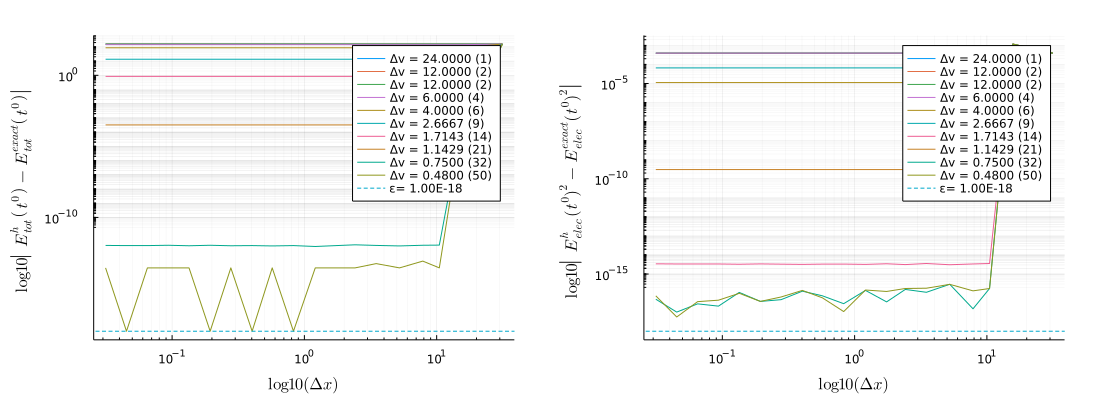

In [246]:
plot(plotEtot, plotEelec, size=(1100, 400), margins=7Plots.mm)

# Increasing number of velocity points

In [251]:
function varying_Δv_for_multiple_Δx()
    nbpts_Δv = 20
    arr_nx_Δv = convert.(Int64, round.(10 .^ range(0.0, log10(50), length=10)))
    arr_nv_Δv = convert.(Int64, round.(10 .^ range(0.0, 3, length=nbpts_Δv)))

    Eelec²_Δv = Vector{Float64}(undef, nbpts_Δv)
    Etot²_Δv = Vector{Float64}(undef, nbpts_Δv)
    ∫v²fdxdv_Δv = Vector{Float64}(undef, nbpts_Δv)
    C_Δv = Vector{Float64}(undef, nbpts_Δv)

    plotEtot = plot(minorgrid=true,
    xlabel=L"\log10(\Delta v)",                 
    axis=:log,
    ylabel=L"\log10\left| E_{tot}^h\left( t^0 \right) - E_{tot}^{exact}\left( t^0 \right) \right|",
    legend=:best)

    plotEelec = plot(minorgrid=true,
        xlabel=L"\log10(\Delta v)",                 
        axis=:log,
        ylabel=L"\log10\left|E_{elec}^h(t^0)^2 - E_{elec}^{exact}(t^0)^2\right|",
        legend=:best)    
    
        ε = 10^-18
    
    for (ix, nxiter_Δv) = enumerate(arr_nx_Δv)

        Etot²_Δv .= 0
        Eelec²_Δv .= 0
        ∫v²fdxdv_Δv .= 0
        C_Δv .= 0

        for (iv, nviter_Δv) = enumerate(arr_nv_Δv)
            quadrulex_Δv = quadX(nxiter_Δv, 0, example.L);
            quadrulev_Δv = quadV(nviter_Δv, example.vmin, example.vmax);
            nbparticles_Δv = nxiter_Δv*nviter_Δv
            x0_Δv = copy(vec(repeat(quadrulex_Δv.points, 1, nviter_Δv)))
            v0_Δv = copy(vec(repeat(quadrulev_Δv.points', nxiter_Δv, 1)))
            weights_Δv = quadrulex_Δv.weights .* quadrulev_Δv.weights'
            wei_Δv = vec(example.f0.(quadrulex_Δv.points, quadrulev_Δv.points') .* weights_Δv)
            particles_Δv = Particles(x0_Δv, v0_Δv, wei_Δv, nbparticles_Δv);
            
            C₁_Δv = sum(cos.(example.kx .* particles_Δv.x) .* particles_Δv.wei)
            S₁_Δv = sum(sin.(example.kx .* particles_Δv.x) .* particles_Δv.wei)

            Φ = (cos.(example.kx .* particles_Δv.x) .* C₁_Δv .+ 
                    sin.(example.kx .* particles_Δv.x) .* S₁_Δv) .* example.L ./ (2π^2)

            # Eelec²_Δx[i] = sum(particles_Δx.wei .* Φ)
            Eelec²_Δv[iv] = example.L/(2*π^2) * (C₁_Δv^2 + S₁_Δv^2)
            ∫v²fdxdv_Δv[iv] = sum(particles_Δv.v.^2 .* particles_Δv.wei)
            C_Δv[iv] = C₁_Δv
        end
        Etot²_Δv .= (Eelec²_Δv + ∫v²fdxdv_Δv)./2;

        dv = (example.vmax - example.vmin) ./ arr_nv_Δv
        dx = example.L / nxiter_Δv
    
        # Pour afficher l'erreur sur l'energie totale :
        plot!(plotEtot, dv, max.(abs.(Etot²_Δv .- example.Etot²exact), ε),
            label="Δx = $(@sprintf("%.4f", dx)) ($(nxiter_Δv))")

        # Pour afficher l'erreur sur l'energie electrique :
        plot!(plotEelec, dv, max.(abs.( Eelec²_Δv .- example.L / (2π^2) * example.α^2 * example.L^2/4), ε),
            label="Δx = $(@sprintf("%.4f", dx)) ($(nxiter_Δv))")
    
    end
    return plotEtot, plotEelec
end

varying_Δv_for_multiple_Δx (generic function with 1 method)

In [252]:
plotEtot, plotEelec = varying_Δv_for_multiple_Δx();

In [253]:
hline!(plotEtot, [ε], labels="ε= $(@sprintf("%.2E", ε))", ls=:dash);
hline!(plotEelec, [ε], label="ε= $(@sprintf("%.2E", ε))", ls=:dash);

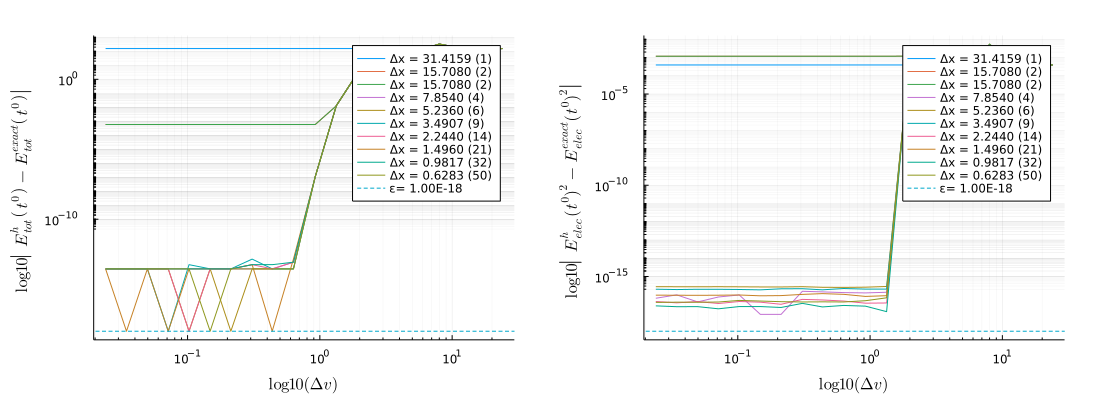

In [254]:
plot(plotEtot, plotEelec, size=(1100, 400), margins=7Plots.mm)

# Varying time step